# Multi-Input Sexual Trafficking Identification Model

# Load Libraries

In [1]:
######################################################Initial Packages########################################################
#Basic Operating System Stuff
import sklearn
import os
import gc #garbage collector
import random #random seed generator
import sys
import csv
import subprocess

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Sci-kit Learn
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.metrics import classification_report as cr
from sklearn.model_selection import train_test_split as tts

#Tensorflow
import tensorflow as tf #backend for keras
from tensorflow.python.client import device_lib #to  see if my GPU is alive!
import tensorflow.keras #keras
from tensorflow.keras import Sequential,Input,Model #pull in the sequential, input layers and a model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Embedding, Bidirectional, Dense, LSTM, Concatenate, concatenate #pull in the dense, dropout, and flatten layers
from tensorflow.keras.layers import Add, Activation, ZeroPadding2D, MaxPool2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB6#MobileNetV2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint # ReduceLROnPlateau, use for early stopping and reduction on level-out
from tensorflow.keras import utils #Need utilities for the layers
from tensorflow.keras.utils import get_file, plot_model #To load certain files & plot models
import tensorflow.keras.backend as K #To write our own metrics and loss functions
from tensorflow.keras.preprocessing.text import Tokenizer #RNN
from tensorflow.keras.preprocessing.sequence import pad_sequences #RNN

#Graphing
import matplotlib #image save
import matplotlib.pyplot as plt #plotting
from matplotlib.pyplot import imshow #Show images
from PIL import Image, ImageFont, ImageDraw
import glob
import cv2

#Directory

os.chdir("D:/Sexual_Trafficking")

%matplotlib inline

#Verify GPU recognition
print(device_lib.list_local_devices()) #Let's see if Python recognizes my GPU, shall we?
##############################################################################################################################

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16569692599566966306
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2142627670065962457
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6918604064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15427259215676716030
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Super, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9610844616156978247
physical_device_desc: "device: XLA_GPU device"
]


# Memory Management

In [2]:
#################################################Memory Mgt / Directory Load###################################################
def reset_keras():
    tf.keras.backend.clear_session #This clears the GPU session
    gc.collect()
reset_keras()            
################################################################################################################################

# Emoji  Specific Loading

In [3]:
#Basic NLP toolkit stuff
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
import re
import spacy
from spacymoji import Emoji
import pickle



# Read Data 

In [4]:
mydf = pd.read_csv('data.csv', encoding="utf8") #read original data
mydf['both']=mydf['title']+' '+mydf['body']     #combine title and body data to extract Emojis
mydf.head()

,id,label,title,body,both
0,2632347,4,Ms Chrissy - 22,Tall <br> Sexy<br> Slim<br> 100% real<br> Reas...,Ms Chrissy - 22 Tall <br> Sexy<br> Slim<br> 10...
1,11645643,1,Everybody loves a Filipina Girl - 29,Hi there Boys it's Miss Sweet 1OO% Filipina gi...,Everybody loves a Filipina Girl - 29 Hi there ...
2,15199346,4,NEW Sexy Asian girl⛔️⛔️⛔️⛔️⛔️SUPER HOOOT⛔️⛔️⛔️...,Hello Gentlemen⚜⚜<br> I am Mimi Asian Girl <br...,NEW Sexy Asian girl⛔️⛔️⛔️⛔️⛔️SUPER HOOOT⛔️⛔️⛔️...
3,14477454,0,Freaky . TS 🍆🍑 TOP AND BOTTOM (9INCH) fun pack...,• So Treat Yourself to Heaven on Earth...🌍 YOU...,Freaky . TS 🍆🍑 TOP AND BOTTOM (9INCH) fun pack...
4,11266475,2,❤Kinky Kaylani👑Rear Access &VIP visits👑Great R...,Aren't you tired of the old bait and switch or...,❤Kinky Kaylani👑Rear Access &VIP visits👑Great R...


# Load Emoji Handling Package

In [6]:
spacy.prefer_gpu()                 #use the GPU if available
nlp = spacy.load("en_core_web_lg") #load the large version of the emojis
emoji = Emoji(nlp)                 #initialize Emoji set
nlp.add_pipe("emoji", first=True)  #add emoji pipeline
nlp.pipe_names                     #enumerate nlp pipeline
#'emoji': ID emoji, 'tok2vec': tokenize unigrams / bigrams,  'tagger':part of speech, 'parser': dependency parser
#'attribute_ruler': exception handling, 'lemmatizer': lemma,  'ner': named entity recognizer

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

# Look at the Emoji's

# All Emojis from Title & Body

In [8]:
tmp=mydf.values #get the dataframe values

def extract_emojies(x):     #define function
  tmp = nlp(str(x['both'])) #get both the title and body text
  emojis = [token.text for token in tmp if token._.is_emoji] #get the emoji tokens
  return emojis

emojies_df_both = mydf.apply(extract_emojies, axis=1) #look at the emojis in the title only (quicker)
print(emojies_df_both)

del tmp
reset_keras()

0                                                       []
1                                                       []
2        [⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⛔, ⚜, ...
3                     [🍆, 🍑, 🎉, 🎊, 🌍, 👉, 👉, 👉, 👉, 👉, 🍃, 🙌]
4                                          [❤, 👑, 👑, ❤, ❤]
                               ...                        
12345                                                   []
12346                       [📒, 📒, 📒, 📒, 📒, 📒, 📒, 📒, 📒, 📒]
12347                       [💝, 👑, 👑, 👑, 💎, 💎, 💎, 👑, 👑, 👑]
12348                                               [☎, ➡]
12349              [💘, 💘, 💘, 💘, 🌹, 🌹, 🌹, 🌹, 🌹, 🌹, 🌹, 🌹, 🌹]
Length: 12350, dtype: object


In [9]:
print(np.argmax(emojies_df_both.astype('str').str.len()))
len(emojies_df_both[7671])

7671


179

# Arrange Emojis

In [56]:
test=emojies_df_both
images=[]
sizes=[]

for i in range(len(emojies_df_both)):
    length=len(emojies_df_both[i])
    size=math.ceil(length**.5)
    zeros=size**2-length
    #print(zeros)
    tmp=test[i]+['']*zeros
    images.append(np.asarray(tmp).reshape(size,size))
    sizes.append(size)
images[3000]


array([['👙', '❤', '❤', '👙'],
       ['♥', '♥', '♥', '☎'],
       ['☎', '♥', '♥', '♥'],
       ['♥', '', '', '']], dtype='<U1')

# Make Color Images from Emojis

In [92]:
imsize=224 # set image size
np.set_printoptions(threshold = sys. maxsize) 

z=0

for i in np.arange(len(emojies_df_both)):
    mysize=sizes[i]+1
    image = Image.new('RGB', (mysize*50,mysize*50), 'white')
    font = ImageFont.truetype('seguiemj.ttf', size=35)
    draw = ImageDraw.Draw(image)
    tmp=str(images[z]).replace("'", "").replace('[','').replace(']','')
    draw.text((2, 10), tmp, (0, 0, 0), font=font,embedded_color=True)
    image=image.resize((imsize,imsize))
    image.save('D:/Sexual_Trafficking/TotalImages/Image_' + str(z) + '.jpg')
    z+=1

 # Count the Emojis / Special Words

In [93]:
emcount1=[] #counts
emcount2=[]
pcount1=[] #proportions
pcount2=[]
sexcount1=[] #counts for derivatives of sex
sexcount2=[]
psexcount1=[] #proportions for derivatives of sex
psexcount2=[]

for i in range(len(mydf)):
    l1=len(str(mydf.iloc[i,2]))
    l2=len(str(mydf.iloc[i,3]))
    st1=str(mydf.iloc[i,2])
    st2=str(mydf.iloc[i,3])
    tmp1=nlp(st1)
    tmp2=nlp(st2)
    emcount1.append(len(tmp1))
    emcount2.append(len(tmp2))
    pcount1.append(len(tmp1)/(l1+.1))
    pcount2.append(len(tmp2)/(l2+.1))
    tmp3=len(re.findall(r's\s*e\s*x\s*',st1, re.IGNORECASE)) #find the word sex with or without spaces
    tmp4=len(re.findall(r's\s*e\s*x\s*',st2, re.IGNORECASE)) #same here
    sexcount1.append(tmp3)
    sexcount2.append(tmp4)
    psexcount1.append(tmp3/(l1+.1))
    psexcount2.append(tmp4/(l2+.1))                 

    
mydf['num_title_emojis']=emcount1 #add to dataframe
mydf['num_body_emojis']=emcount2
mydf['num_title_sex']=sexcount1
mydf['num_body_sex']=sexcount2

mydf['prop_title_emojis']=pcount1
mydf['prop_body_emojis']=pcount2
mydf['prop_title_sex']=psexcount1
mydf['prop_body_sex']=psexcount2

# Build Variables for Files

In [94]:
myf3=glob.glob('D:/Sexual_Trafficking/TotalImages/*.jpg')
myf3.sort(key=lambda f: int(re.sub('\D', '', f)))
mydf['TotalImages']=myf3
mydf.to_csv('D:/Sexual_Trafficking/expanded.csv', index=False)
reset_keras()

# Plot the Relative Frequency Distribution

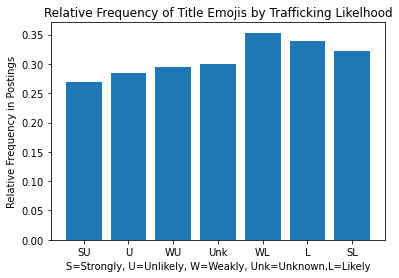

In [95]:
tmp4=mydf.groupby('label')['prop_title_emojis'].mean()
myseq=['SU','U','WU','Unk','WL','L', 'SL']
plt.bar(myseq,tmp4)
plt.title('Relative Frequency of Title Emojis by Trafficking Likelhood')
plt.xlabel('S=Strongly, U=Unlikely, W=Weakly, Unk=Unknown,L=Likely')
plt.ylabel('Relative Frequency in Postings')

del tmp4

reset_keras()

# Recode Emojis / Emoticons to Text, Remove Stopwords / Punctuation, Convert to Lower Case / Remove Numbers

In [96]:
import nltk
import string
from num2words import num2words
from string import punctuation
from emot.emo_unicode import UNICODE_EMOJI 
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

#nltk.download('stopwords')
#nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def clean_html(text):
  CLEANR = re.compile('<.*?>') 
  text = re.sub(CLEANR, '', text)
  return text

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot]+" ".replace("",""))
    return text

def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot,UNICODE_EMOJI[emot]+" ".replace("",""))
    return text

def remove_stopwords(text):
    return [word for word in word_tokenize(text) if not word in stopwords]

def strip_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)+' '    

def to_number(text):    
    return(re.sub(r"(\d+)", lambda x: num2words(int(x.group(0))), text))

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return ' '.join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# NLP Apply

In [97]:
mydf['title']=mydf['title'].str.lower()
mydf['title']=mydf['title'].astype(str).apply(clean_html)
mydf['title']=mydf['title'].astype(str).apply(convert_emoticons)
mydf['title']=mydf['title'].astype(str).apply(convert_emojis)
mydf['title']=mydf['title'].astype(str).apply(remove_stopwords)
mydf['title']=mydf['title'].astype(str).apply(strip_punctuation)
mydf['title']=mydf['title'].astype(str).apply(to_number)
mydf['title']=mydf['title'].astype(str).apply(lemmatize_words)

mydf['body']=mydf['body'].str.lower()
mydf['body']=mydf['body'].astype(str).apply(clean_html)
mydf['body']=mydf['body'].astype(str).apply(convert_emoticons)
mydf['body']=mydf['body'].astype(str).apply(convert_emojis)
mydf['body']=mydf['body'].astype(str).apply(remove_stopwords)
mydf['body']=mydf['body'].astype(str).apply(strip_punctuation)
mydf['body']=mydf['body'].astype(str).apply(to_number)
mydf['body']=mydf['body'].astype(str).apply(lemmatize_words)
mydf

,id,label,title,body,both,num_title_emojis,num_body_emojis,num_title_sex,num_body_sex,prop_title_emojis,prop_body_emojis,prop_title_sex,prop_body_sex,TotalImages
0,2632347,4,ms chrissy twenty-two,tall sexy slim one hundred real reasonable cle...,Ms Chrissy - 22 Tall <br> Sexy<br> Slim<br> 10...,4,64,0,1,0.264901,0.333160,0.000000,0.005206,D:/Sexual_Trafficking/TotalImages\Image_0.jpg
1,11645643,1,everybody love filipina girl twenty-nine,hi boys s miss sweet oneoo filipina girl kai l...,Everybody loves a Filipina Girl - 29 Hi there ...,7,96,0,0,0.193906,0.244836,0.000000,0.000000,D:/Sexual_Trafficking/TotalImages\Image_1.jpg
2,15199346,4,new sexy asian girl noentry ️ noentry ️ noentr...,hello gentleman fleurdelis fleurdelis mimi asi...,NEW Sexy Asian girl⛔️⛔️⛔️⛔️⛔️SUPER HOOOT⛔️⛔️⛔️...,37,124,1,1,0.410655,0.286971,0.011099,0.002314,D:/Sexual_Trafficking/TotalImages\Image_2.jpg
3,14477454,0,freaky t eggplant peach top bottom nineinch fu...,• treat heaven earth globeshowingEuropeAfrica ...,Freaky . TS 🍆🍑 TOP AND BOTTOM (9INCH) fun pack...,18,63,0,0,0.299501,0.302739,0.000000,0.000000,D:/Sexual_Trafficking/TotalImages\Image_3.jpg
4,11266475,2,redheart kinky kaylani crown rear access vip v...,nt tired old bait switch picture tenyr old twe...,❤Kinky Kaylani👑Rear Access &VIP visits👑Great R...,21,116,0,0,0.233074,0.236686,0.000000,0.000000,D:/Sexual_Trafficking/TotalImages\Image_4.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12345,11119322,5,houston outcall beautiful asian girl julie twe...,hello gentleman name julie twenty-three year o...,Houston Outcall Only *~*~*~*~* Beautiful Asian...,18,93,0,1,0.204313,0.242756,0.000000,0.002610,D:/Sexual_Trafficking/TotalImages\Image_12345.jpg
12346,5727617,1,stag party stripper two hundred and fiftyhr tw...,call toll free one visit angel eyez seven webs...,STAG PARTY STRIPPERS $250HR For 2 ExoTic STrip...,26,73,0,0,0.291807,0.089670,0.000000,0.000000,D:/Sexual_Trafficking/TotalImages\Image_12346.jpg
12347,8395124,5,heartwithribbon asian girl jane crown crown cr...,hey guy name jane wellreviewed openminded hot ...,💝 Asian Girl Jane 👑👑👑 💎 Busty 💎 Sexy 💎 👑👑👑 O...,21,98,1,0,0.308370,0.242514,0.014684,0.000000,D:/Sexual_Trafficking/TotalImages\Image_12347.jpg
12348,1549586,5,new ★ massage best sensual adult health offer ...,enjoy new moonlight spa nt hesitate experience...,NEW ★ Our massage is best for sensual Adult he...,20,128,0,0,0.195886,0.212237,0.000000,0.000000,D:/Sexual_Trafficking/TotalImages\Image_12348.jpg


# Delete ID, Both, & Indices

In [98]:
mydf=mydf.drop(columns=['id', 'both']) #drop ID and Both columns
mydf = mydf.reset_index(drop=True) #reset the index
reset_keras() #take out the papers and the trash
mydf.columns

Index(['label', 'title', 'body', 'num_title_emojis', 'num_body_emojis',
       'num_title_sex', 'num_body_sex', 'prop_title_emojis',
       'prop_body_emojis', 'prop_title_sex', 'prop_body_sex', 'TotalImages'],
      dtype='object')

# Write to CSV

mydf.to_csv('D:/Sexual_Trafficking/ht.csv', index=False)

# Initialize Model Settings

In [3]:
reset_keras()
mybatch=32   #set batch size
embedding_size=512 #set out size for embedding
num_epochs=4 #set the number of epochs...3 is optimal for most model combinations
num_words = 50000     #number of words to tokenize, 50000 was start
tf.random.set_seed(1234) #set random number seed for tensorflow, python, etc.

# Reload Data 

In [4]:
mydf=pd.read_csv('D:/Sexual_Trafficking/ht.csv') #cleaned and engineered data
mydict={0:0, 1:0, 2:0, 3:0, 4:1, 5:1, 6:1} #dictionary mapping of values to binary
mydf['label']=mydf['label'].replace(dict(mydict)) #replacing values
#print(np.bincount(mydf['label'].values)) #count
mydf['text']=mydf['title']+' '+mydf['body']
mydf=mydf.drop(columns=['title','body'])
mydf.head()

,label,num_title_emojis,num_body_emojis,num_title_sex,num_body_sex,prop_title_emojis,prop_body_emojis,prop_title_sex,prop_body_sex,TotalImages,text
0,1,4,64,0,1,0.264901,0.333160,0.000000,0.005206,D:/Sexual_Trafficking/TotalImages\Image_0.jpg,ms chrissy twenty-two tall sexy slim one hundr...
1,0,7,96,0,0,0.193906,0.244836,0.000000,0.000000,D:/Sexual_Trafficking/TotalImages\Image_1.jpg,everybody love filipina girl twenty-nine hi bo...
2,1,37,124,1,1,0.410655,0.286971,0.011099,0.002314,D:/Sexual_Trafficking/TotalImages\Image_2.jpg,new sexy asian girl noentry ️ noentry ️ noentr...
3,0,18,63,0,0,0.299501,0.302739,0.000000,0.000000,D:/Sexual_Trafficking/TotalImages\Image_3.jpg,freaky t eggplant peach top bottom nineinch fu...
4,0,21,116,0,0,0.233074,0.236686,0.000000,0.000000,D:/Sexual_Trafficking/TotalImages\Image_4.jpg,redheart kinky kaylani crown rear access vip v...


# Train Test Split

In [5]:
x_train, x_test, y_train, y_test = tts(mydf.iloc[:,1:11], mydf['label'], test_size=0.2, random_state=42) #split
print(np.bincount(y_train)) #print y train values
print(np.bincount(y_test))  #print y test values
print(x_train.columns)      #print x training columns

[6638 3242]
[1658  812]
Index(['num_title_emojis', 'num_body_emojis', 'num_title_sex', 'num_body_sex',
       'prop_title_emojis', 'prop_body_emojis', 'prop_title_sex',
       'prop_body_sex', 'TotalImages', 'text'],
      dtype='object')


# Make Data Sets

In [6]:
x_train1=x_train['text']         #text from title and body
x_train3=x_train.iloc[:,0:8]     #training for engineered features
x_test1=x_test['text']           #test for title RNN
x_test3=x_test.iloc[:,0:8]       #test for engineered features
x_train3

,num_title_emojis,num_body_emojis,num_title_sex,num_body_sex,prop_title_emojis,prop_body_emojis,prop_title_sex,prop_body_sex
10132,63,87,1,2,0.623145,0.261969,0.009891,0.006022
4484,6,40,0,0,0.206186,0.228441,0.000000,0.000000
11620,14,79,0,1,0.273973,0.251512,0.000000,0.003184
3328,23,91,0,0,0.302234,0.256990,0.000000,0.000000
3115,28,378,1,1,0.271581,0.206321,0.009699,0.000546
...,...,...,...,...,...,...,...,...
11964,18,131,0,0,0.294599,0.301080,0.000000,0.000000
5191,7,118,0,0,0.082256,0.270580,0.000000,0.000000
5390,20,82,0,0,0.316957,0.288631,0.000000,0.000000
860,14,32,0,1,0.263653,0.257857,0.000000,0.008058


# Min Max Scale for Continuous Variables

In [7]:
transform=mms() #declare min max scaler
x_train3=transform.fit_transform(x_train3)   #fit transform training data
x_test3=transform.transform(x_test3)         #transform test data                                                 

# Tokenize Text Data

In [8]:
oov_token = '<UNK>'   #out of vocabulary replacement
pad_type = 'post'     #padding type
trunc_type = 'post'   #truncation type

tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

tokenizer.fit_on_texts(x_train1.astype('str'))
#tokenizer.fit_on_texts(x_train2.astype('str'))

# Encode training data sentences into sequences
train_sequences1 = tokenizer.texts_to_sequences(x_train1.astype('str')) 

# Get max training sequence length
maxlen1 = max([len(x) for x in train_sequences1])

# Pad the training sequences to the maximum sentence length
x_train1 = pad_sequences(train_sequences1, padding=pad_type, truncating=trunc_type, maxlen=maxlen1)

# Tokenize Test Data

In [9]:
# Encode test data sentences into sequences
test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype('str'))

# Pad the training sequences to the maximum sentence length of training set
x_test1 = pad_sequences(test_sequences1, padding=pad_type, truncating=trunc_type, maxlen=maxlen1)

# Clean Up

In [10]:
del train_sequences1
del test_sequences1
del mydf
reset_keras()

# Multi-Input Model

## Input Shapes

In [11]:
input_1 = Input(shape=(x_train1.shape[1]))
input_3 = Input(shape=(8))

## RNN

In [12]:
v=Embedding(len(tokenizer.word_index) + 1, embedding_size)(input_1)
v=Bidirectional(LSTM(embedding_size, return_sequences=True, dropout=.5))(v)
v=Bidirectional(LSTM(embedding_size, return_sequences=False, dropout=.2))(v)

## NN

In [13]:
y=Dense(64)(input_3)
y=Dropout(.5)(y)
y=Dense(32)(y)
y=Dropout(.2)(y)

## Concatenate Models

In [14]:
concat=tf.keras.layers.concatenate([v,y], axis=-1)
output=Dense(16,activation='relu')(concat)
output=Dropout(.1)(output)
output=Dense(8, activation='relu')(output)
output=Dense(1, activation='sigmoid')(output)
model=Model(inputs=[input_1, input_3], outputs=output)

# Compile

In [15]:
with tf.device('/GPU:0'):    
    model = model
    SGD= tensorflow.keras.optimizers.SGD(lr=0.0001, nesterov=True)
    adam=tensorflow.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss=tensorflow.keras.losses.binary_crossentropy, 
              optimizer=adam, metrics=['binary_accuracy'])
    model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 622)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           576         input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 622, 512)     15078912    input_1[0][0]                    
_______________________________________________________________________________________

## Plot Model

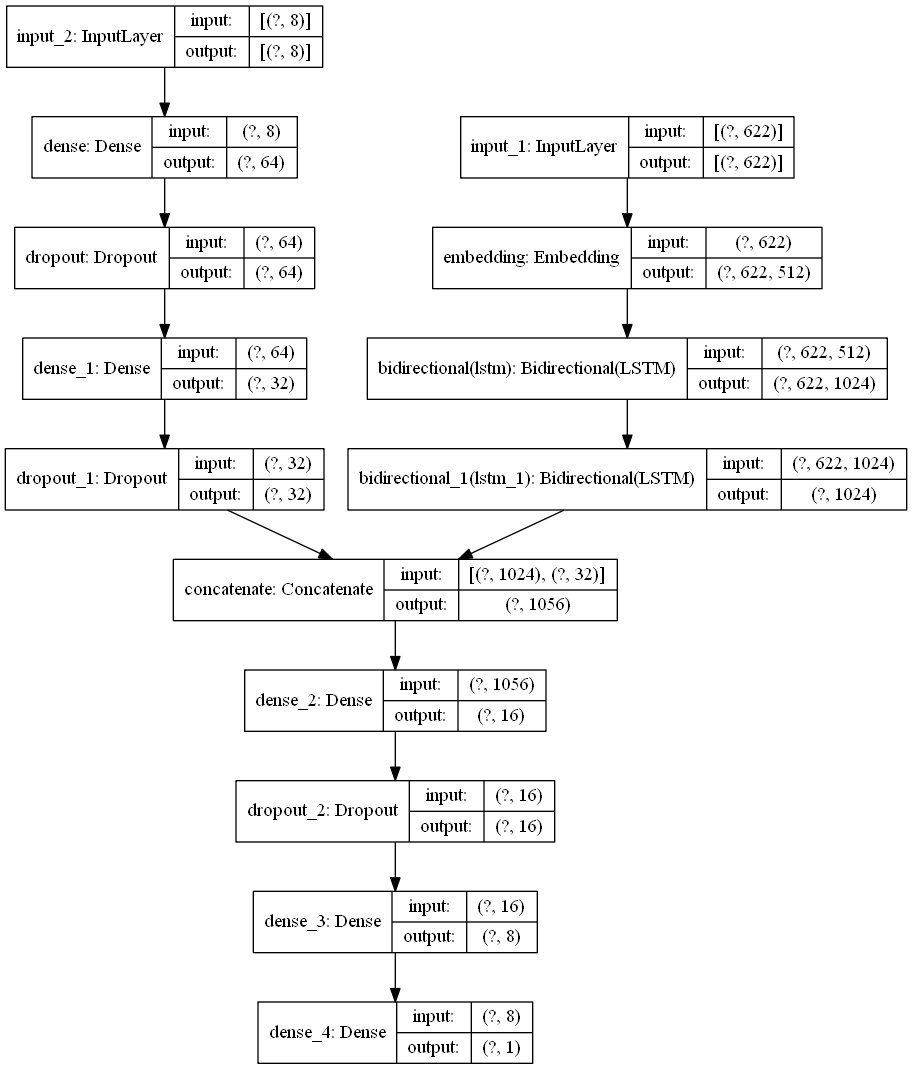

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True, expand_nested=False)

# Prepare for Model Run

In [17]:
tf.config.run_functions_eagerly(True)
reset_keras()
#x_train2=np.reshape(total_train,(len(y_train),mysize,mysize,3))
#x_test2=np.reshape(total_test,(len(y_test),mysize,mysize,3))
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='binary_accuracy', verbose=2,
    save_best_only=True, mode='auto')

# Model Run

In [20]:
#model.load_weights('best_model.hdf5')
reset_keras()

with tf.device('/GPU:0'):    
    history=model.fit(
                  x=[x_train1, 
                     x_train3],y=y_train,
                  batch_size=mybatch,verbose=1,epochs=num_epochs, callbacks=[checkpoint]) 
    
#validation_split=.1 removed after tuning models
#2 epochs works well (hyperparameter tuning)

Epoch 1/2
309/309 [==============================] - ETA: 0s - loss: 0.3605 - binary_accuracy: 0.8482
Epoch 00001: binary_accuracy improved from 0.82085 to 0.84818, saving model to best_model.hdf5
309/309 [==============================] - 191s 619ms/step - loss: 0.3605 - binary_accuracy: 0.8482
Epoch 2/2
309/309 [==============================] - ETA: 0s - loss: 0.2981 - binary_accuracy: 0.8776
Epoch 00002: binary_accuracy improved from 0.84818 to 0.87763, saving model to best_model.hdf5
309/309 [==============================] - 198s 641ms/step - loss: 0.2981 - binary_accuracy: 0.8776


# Evaluate on Test Set

In [21]:
score=model.evaluate([x_test1, x_test3], y=y_test)

78/78 [==============================] - 11s 141ms/step - loss: 0.4398 - binary_accuracy: 0.8162


# Predict on Test Set

In [22]:
predict=model.predict([x_test1, x_test3])
predict1=np.squeeze(predict)
predict1=np.round(predict,0)

# Generate Metrics

In [23]:
print(cr(y_test, predict1))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1658
           1       0.76      0.65      0.70       812

    accuracy                           0.82      2470
   macro avg       0.80      0.77      0.78      2470
weighted avg       0.81      0.82      0.81      2470



In [43]:
a=np.array([y_test,np.squeeze(predict1)]).T
a=pd.DataFrame(a, columns=['True','Predicted'])
means =a.groupby('True').mean()
sub=a[a['Predicted']>.99]
sub.mean()

True         0.778116
Predicted    1.000000
dtype: float64

# Plot Accuracy

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()